## Original Notebook classifying all 4 classes:
- 0 : Glioma Tumor
- 1 : Meningioma Tumor
- 2 : No Tumor
- 3 : Pituitary Tumor

In [26]:
import sys
sys.path.append('../src/')

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
import random
import mlflow
import Data_Augmentation
import Data_Loader
import Plotting_functions
import Model_Builder
import Data_Cleaning
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import to_categorical

from Data_Loader import DataLoader
from Data_Augmentation import Data_Augmentation
from Data_Cleaning import Cleaner
from Plotting_functions import Plotting_functions
from Model_Builder import CNNModel


In [28]:
#Initialise class
data_loader = DataLoader()
Augmentator = Data_Augmentation()
ModelBuilder = CNNModel()
Cleaning = Cleaner(ModelBuilder)



### Data Source: [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

In [29]:
training_path = '/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Images_Brain/Training'
testing_path = '/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Images_Brain/Testing'

In [30]:
# Checking to see the different folders within our path
for image_class in os.listdir(training_path):
  print(image_class)


no_tumor
meningioma_tumor
glioma_tumor
pituitary_tumor


In [31]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

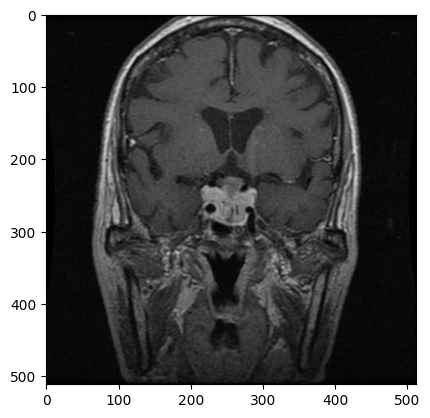

In [32]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

# Loading data

The datset was already split into testing and training data so we do not need to define these later

In [33]:
# Load the training dataset
Training_data = data_loader.Load_Training_data(training_path)
# Load the validation dataset
Validation_data = data_loader.Load_Validaion_data(training_path)
# Load the testing dataset
Testing_data = data_loader.Load_Testing_data(testing_path)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [34]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()
batch_training = Training_iterator.next()

# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

#Initialisng Plotting functions class using our labels
Plotter = Plotting_functions(class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [10]:
print(batch_training[0].shape) # Images are now of dimension 256 x 256 x 3 which is wha we want, we have 32 images in this batch
print(batch_training[1]) # Labels are 0,1,2 and 3 for the different classes

(32, 256, 256, 3)
[3 0 2 0 2 2 3 1 1 0 0 3 1 1 1 1 1 0 3 1 2 1 0 1 2 3 3 3 0 3 1 2]


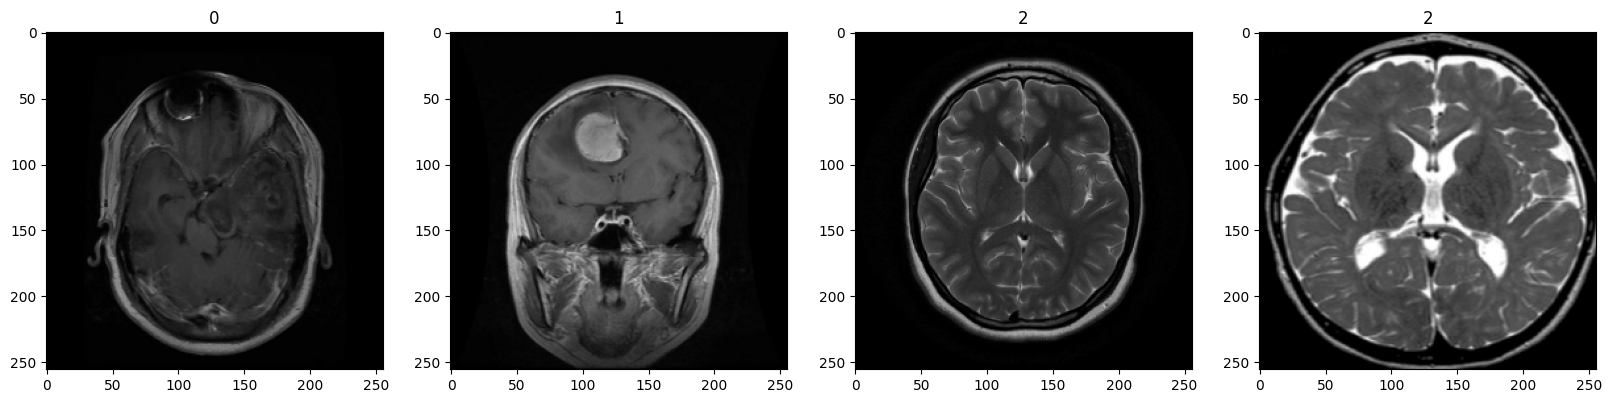

In [11]:
Plotter.plot_tumour(batch_training)

#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


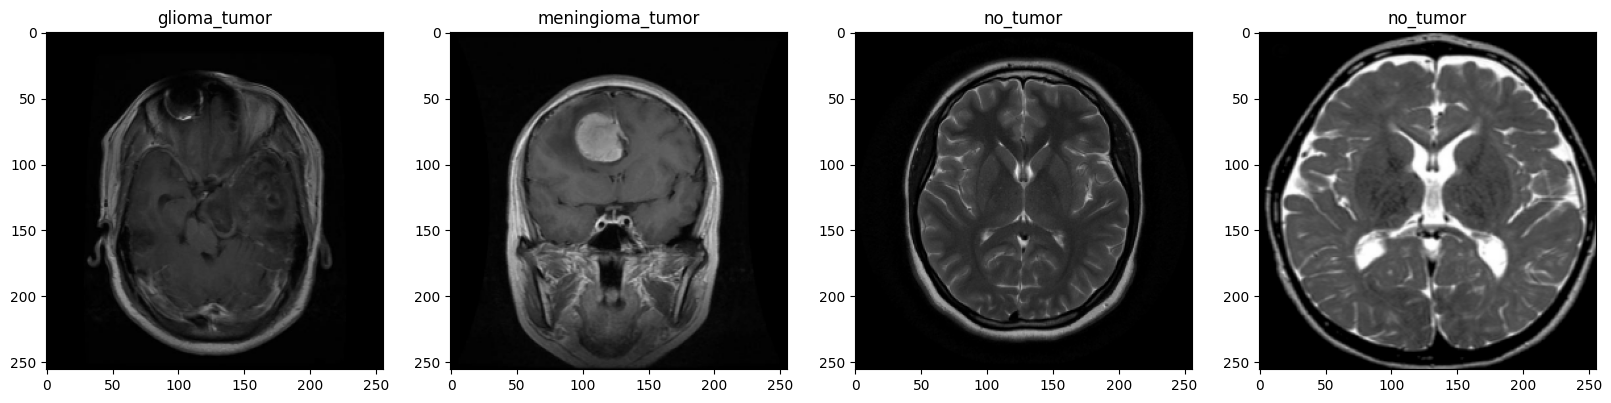

In [12]:
labels = [class_names[label] for label in batch_training[1]]

# Similar plot to earlier but now we have passed through our labels
Plotter.plot_tumour(batch_training, labels)

# Preprocessing Data

In [13]:
num_classes = 4

# Load the training dataset
Training_data = Training_data.map(Augmentator.augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the validation dataset
Validation_data = Validation_data.map(Augmentator.augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
#Validation_data = Validation_data.map(augment_image)
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is Labels


# Deep Model

In [14]:
logdir = "/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Notebooks/logs"

# Build the model with custom hyperparameters
ModelBuilder.build_model()

# Compile the model
ModelBuilder.compile()


ModelBuilder.summary()

# Train the model
hist = ModelBuilder.train(
    Training_data=Training_data,
    Validation_data=Validation_data,
    epochs=15,
    log_dir=logdir,
)

/Users/harjitgakhal/.local/share/virtualenvs/Brain-Tumour-Classification-Lpua87O-/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,816,580 (14.56 MB)

 Trainable params: 3,816,580 (14.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.4398 - loss: 1.8366 - val_accuracy: 0.5244 - val_loss: 1.4521
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6613 - loss: 1.1441 - val_accuracy: 0.5976 - val_loss: 1.3670
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7180 - loss: 0.9474 - val_accuracy: 0.6132 - val_loss: 1.2998
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8023 - loss: 0.7651 - val_accuracy: 0.6202 - val_loss: 1.3293
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.8453 - loss: 0.6988 - val_accuracy: 0.6864 - val_loss: 1.4252
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8593 - loss: 0.6715 - val_accuracy: 0.6882 - val_loss: 1.3503


In [ ]:
# mlflow.log_param("l2_1", l2_1)
# mlflow.log_param("l2_2", l2_2)
# mlflow.log_param("l2_3", l2_3)

## Model Evaluation

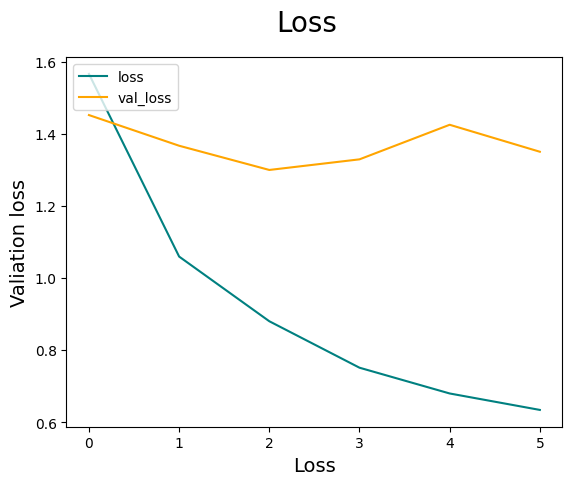

In [20]:
Plotter = Plotting_functions(class_names)

Plotter.plot_loss(hist)

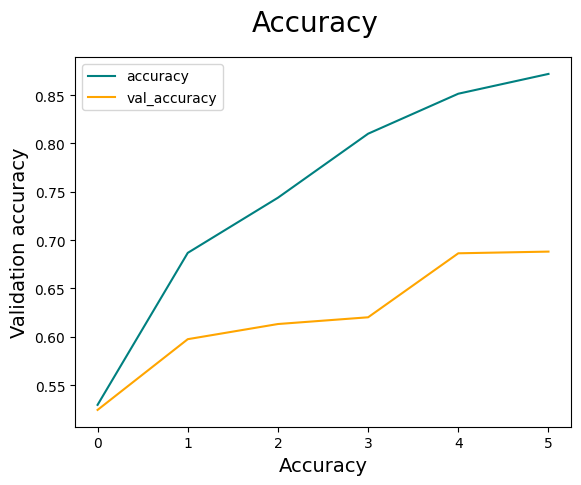

In [21]:
Plotter.plot_accuracy(hist)

## Testing data

In [22]:
X_test, labels_testing = Cleaning.Testing_data_cleaner(Testing_data)

2024-09-02 19:05:57.920690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
y_, yhat_binary, pre, re, acc = Cleaning.y_predictor(
    X_test=X_test, labels_testing=labels_testing
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step
Precision: 0.7804877758026123
Recall: 0.9795918464660645
Accuracy: 0.3350253701210022


## Conclusion

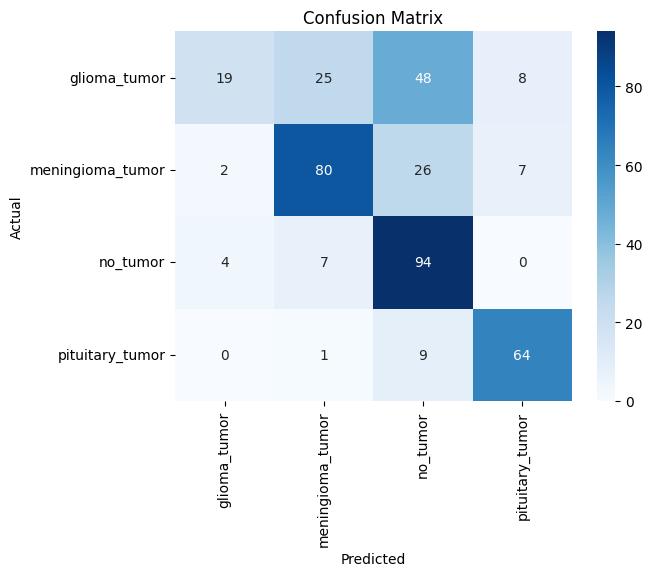

In [24]:
Plotter.plot_confusion_matrix(y_, yhat_binary)

We can say that while Meningioma, Pituitary, and No tumor are being picked up well, Glioma tumor however isn't so easily and is something that would require future work

## Saving model

In [ ]:
#model.save('/content/drive/MyDrive/projects/Brain_Tumor_Classification/model')